# Pneumonia CXR Classification

<center><img src="https://i.imgur.com/jZqpV51.png" width="500"/></center>


Illustrative Examples of Chest X-Rays in Patients with Pneumonia.
The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs. (From Kaggle)

**Content:**

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

## Examining the data

### Imports and opening an image

In [ ]:
import torch
# import torch.nn as nn
# import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# from torchvision.utils import make_grid

import os
from PIL import Image
from IPython.display import display
import numpy as np
import pandas as pd
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# %matplotlib inline

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

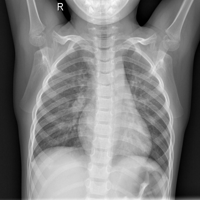

In [29]:
with Image.open('data/train/NORMAL/IM-0115-0001.jpeg') as im:
    im_resized = im.resize((200, 200))
    display(im_resized)

### Inspect the amount of 'Normal' and 'Pneumonia' cases

In [49]:
path = 'data/'
img_names = []
count_normal = 0 
count_pneumonia = 0 

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)

        if 'PNEUMONIA' in folder:
            count_pneumonia += 1
        elif 'NORMAL' in folder:
            count_normal += 1

print('Images: ', len(img_names))
print('Normal count:', count_normal)
print('Pneumonia count:', count_pneumonia)

Images:  5859
Normal count: 1583
Pneumonia count: 4273


Unbalances classes

### Check the size of the images:

In [31]:
img_sizes = []
rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)
        
print(f'Images:  {len(img_sizes)}')
print(f'Rejects: {len(rejected)}')

Images:  5856
Rejects: 3


In [33]:
# Convert the list to a DataFrame
df = pd.DataFrame(img_sizes)

# Run summary statistics on image widths
df[0].describe()

count    5856.000000
mean     1327.880806
std       363.500922
min       384.000000
25%      1056.000000
50%      1281.000000
75%      1560.000000
max      2916.000000
Name: 0, dtype: float64

In [34]:
# Run summary statistics on image heights
df[1].describe()

count    5856.000000
mean      970.689037
std       383.392117
min       127.000000
25%       688.000000
50%       888.000000
75%      1187.000000
max      2713.000000
Name: 1, dtype: float64

This tells us the shortest width is 384, the shortest height is 127, the largest width and height are 2916 qnd 2713. We will resize all to 224x224 otherwise training will take very long.

## Creating the transformers:

**As we do not have that many images to train the data on, we will perform data agmentation by performing the following modifications: horizontal flips, slight rotation of the images, and brightness/contrast variations, in each training epoch.**

torch.Size([1, 224, 224])


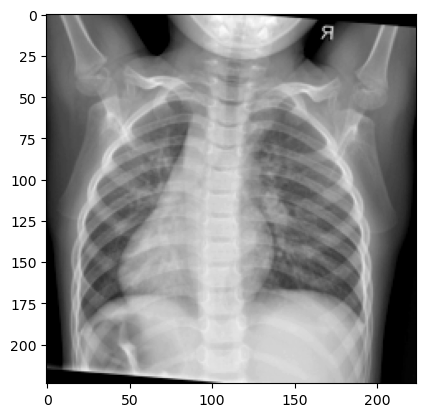

In [260]:
picture = Image.open('data/train/NORMAL/IM-0115-0001.jpeg')

train_transform = transforms.Compose([
    transforms.RandomRotation(5),  # rotate randomly between +/- 5 degrees
    transforms.Resize(224), # Resizes larger dimension to 224 px 
    transforms.CenterCrop(224), # Makes it squared
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip with 0.5 probability
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Brightness and contrast can vary +/- 20%
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # Mapping [0, 1] to [-1, 1], gradientes behave better with zero-centered outputs
])
im = train_transform(picture)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)), cmap='gray');

Our de-normalizator:

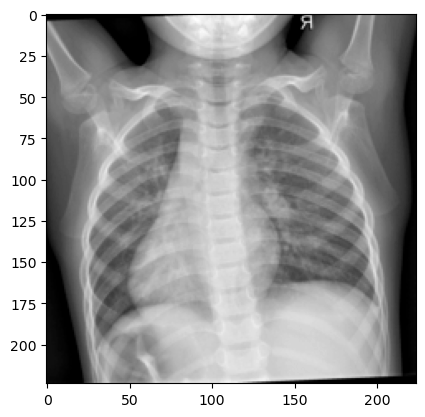

In [244]:
inv_normalize = transforms.Normalize(
    mean=[-1],
    std=[2]
)

inv_normalize(im)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)), cmap='gray');

Out test transformer (we remove the flips, rotations and brightness/contrast modifications)

In [245]:
test_transform = transforms.Compose([
    transforms.Resize(224), # Resizes larger dimension to 224 px 
    transforms.CenterCrop(224), # Makes it squared
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # Mapping [0, 1] to [-1, 1], gradientes behave better with zero-centered outputs
])

## Loading the data, preparing train, validation and test sets

In [261]:
root = 'data'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
val_data = datasets.ImageFolder(os.path.join(root, 'val'), transform=test_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
val_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Validation images available: {len(val_data)}')
print(f'Testing images available:  {len(test_data)}')\

['NORMAL', 'PNEUMONIA']
Training images available: 5216
Validation images available: 16
Testing images available:  624


Display a bunch of images:

Label: [1 1 0 1 1 1 1 1 0 1]
Class: PNEUMONIA PNEUMONIA NORMAL PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA NORMAL PNEUMONIA


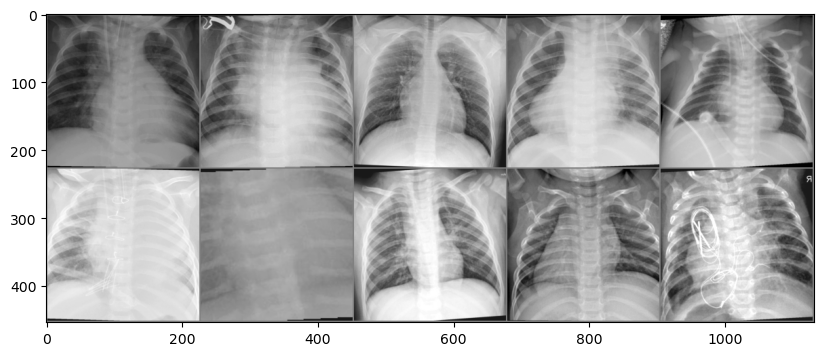

In [262]:
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

from torchvision.utils import make_grid

im = make_grid(images, nrow=5)  # the default nrow is 8

im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));